# Hybrid Time Series Modeling: Univariate Data

Author: **Marcin Sikorski**<br>
Date: July, 2025

**Introduction**

The idea behind a hybrid model is a more advanced approach to time series forecasting by combining the best aspects of econometric and machine learning models - both with different strengths and limitations. Time series data can combine different patterns. Hybridization provides a solution to the dilemma of the assumption of linearity, in contrast to traditional approches where most reach their limits, and improve the overall accuracy. This notebook will explore hybridization for **LSTM** and **XGboost** models. LSTM handles temporal dependencies, capturing complex sequence patterns, while XGBoost is great at modeling non-linear relationships and interactions between features.

Some common hybrid strategies include:
* **feature stacking**: we use the LSTM model to generate hidden representations, and feed those as features into XGBoost;
* **residual learning**: we train LSTM first, extract residuals (errors), then train XGB on those residuals;
* **ensemble averaging**: we train both models independently and average or weight their predictions.

**Dataset Description**

The dataset is from Kaggle and contains only univariate data - most likely fictional - in a continuous matter. Its origin is unknown and no more information, business logic, or features are included. No external factors will be introduced into time series modeling. This notebook will focus clearly only on forecasting, ignoring any business matters.

**Notebook Content**

1. Loading and Exploring Data
2. Anomaly Detection
3. Is Time Series Modeling Possible?
4. Data Preprocessing
5. Developing LSTM
6. Feature Stacking (XGB on LSTM Features)
7. Residual Learning (XGB on LSTM Residuals)
8. Ensemble Averaging
9. Conclusions

### 1. Loading and Exploring Data

The data will be loaded directly from Kaggle via an API. Basic exploratory data analysis (EDA) will be performed to check its completeness, continuity, distribution, and display statistics.

In [ ]:
import kagglehub
import os

# source URL: https://www.kaggle.com/datasets/hardikgarg03/store-sales-time-series-forecasting/data
# API to access Kaggle resources
path = kagglehub.dataset_download('hardikgarg03/store-sales-time-series-forecasting')

print('Path to dataset files:', path)

# list files in the directory
files = os.listdir(path)
print('Files in the dataset directory:', files)

Path to dataset files: /kaggle/input/store-sales-time-series-forecasting
Files in the dataset directory: ['submission.csv']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# path to the CSV file
csv_file = os.path.join(path, 'submission.csv')

# read the CSV file into a pandas dataframe
df = pd.read_csv(csv_file)

# sort the dataframe by 'id' column (in case it's not sorted)
df = df.sort_values(by='id')

# drop possible duplicates
df.drop_duplicates(keep='first', inplace=True)

# display the first few rows
df.head(10)

,id,sales
0,3000888,3.056196
1,3000889,1.445302
2,3000890,13.310976
3,3000891,2216.884255
4,3000892,1.445302
5,3000893,375.566860
6,3000894,10.949825
7,3000895,673.462136
8,3000896,711.105670
9,3000897,131.500153


In [ ]:
# are there missing/NaN values?
df.isna().sum()

,0
id,0
sales,0


In [ ]:
# show summary statistics of numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,28512.0,3.015144e+06,8230.849774,3000888.0,3.008016e+06,3.015144e+06,3.022271e+06,3.029399e+06
sales,28512.0,4.258243e+02,1089.007759,0.0,4.076335e+00,3.135206e+01,2.616633e+02,1.315216e+04


In [ ]:
# check if the 'id' is consecutive (forms a continuous sequence)
# compare the differences between consecutive IDs - if all differences are 1, then the sequence is continuous

# calculate the difference between consecutive IDs
df['id_diff'] = df['id'].diff()

# check if all the differences are equal to 1
missing_ids = df[df['id_diff'] != 1]

# print results
if missing_ids.empty:
    print("The 'id' column is continuous (no missing numbers).")
else:
    print("The 'id' column is not continuous. The following ids are missing or have gaps:")
    #print(missing_ids[['id', 'id_diff']])
    print((df[df['id_diff'] != 1]))

The 'id' column is not continuous. The following ids are missing or have gaps:
        id     sales  id_diff
0  3000888  3.056196      NaN


> The `id` column is continuous. First row obviously will not have a difference because there is no date before that.

The summary shows there are 0.0 sale values. Let's see how much numerous they are.

In [ ]:
# display zero sales rows
df[df['sales'] == 0.0]

,id,sales,id_diff
11110,3011998,0.0,1.0
11980,3012868,0.0,1.0
11983,3012871,0.0,1.0
11996,3012884,0.0,1.0
12013,3012901,0.0,1.0
12016,3012904,0.0,1.0
12029,3012917,0.0,1.0
12178,3013066,0.0,1.0
12181,3013069,0.0,1.0
12194,3013082,0.0,1.0


In [ ]:
# count the number of rows where sales = 0.00
zero_sales_count = (df['sales'] == 0).sum()

print(f'Number of zero sales: {zero_sales_count}')

Number of zero sales: 11


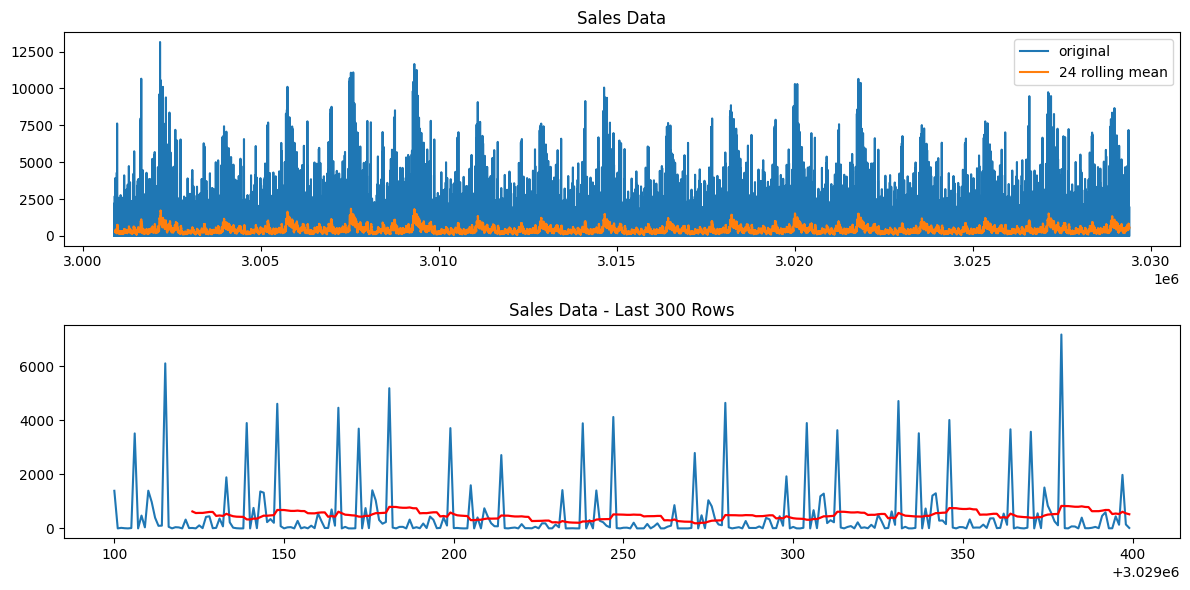

In [ ]:
fig, axes = plt.subplots(
    nrows=2, ncols=1,
    sharex=False,
    figsize=(12, 6),
    tight_layout=True,
    gridspec_kw={'height_ratios': [2, 2]},
    )

# original and moving averages over 24-day windows
axes[0].plot(df['sales'], label='original')
axes[0].plot(df['sales'].rolling(24).mean(), label='24 rolling mean')
axes[0].set_title('Sales Data')
axes[0].legend()

N = 300
# more detail (zoom out last rows)
axes[1].plot(df['sales'].tail(N))
axes[1].plot(df['sales'].tail(N).rolling(24).mean(), lw=1.6, color='red')
axes[1].set_title(f'Sales Data - Last {N} Rows')

plt.show()

> We can notice some periodicity. High sales (spikes) come after small sales in a visible sequence. The contours of rolling means display more sequent data. Conventional machine learning models, such as the ARIMA, would probably struggle modeling this type of time series.

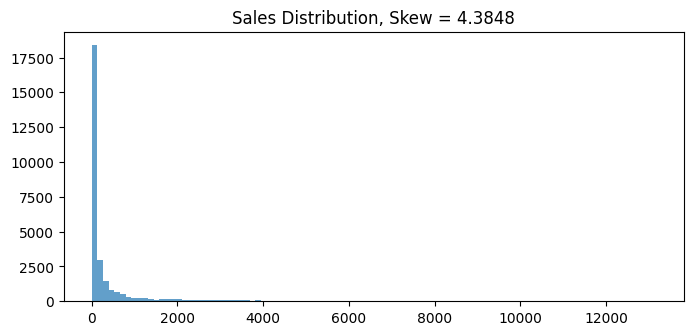

In [ ]:
# visualize the distribution
plt.figure(figsize=(8, 3.5))

plt.hist(df['sales'], bins=100, alpha=0.7)
plt.title(f"Sales Distribution, Skew = {df['sales'].skew():.4f}")

plt.show()

> This distribution has exponential or geometric-like with an extremly long 'tail'. The long tail might suggest that the data is likely heavily right-skewed, which can affect model performance, especially for algorithms that assume normality. For sales data, this type of distribution should be acceptable and it's common to see positive skewness. Sales data often involves many small or moderate transactions, with only a few high-value outliers. Therefore, we will keep the data as it is, without applying transformations.  Tree-based models (random forests, XGBoost, LightGBM, etc.) are robust to skewness and might not need to transform the data. For models that assume normally distributed data (e.g., linear regression, logistic regression, or statistical tests), the long tail could make the model assumptions violated and impact performance. In these cases, it's better to transform the data to stabilize variance and reduce skewness.

### 2. Anomaly Detection

Very high values aren't unusual for sales data. These instances do not necessary mean they are outliers and actualy highlight very successful events. However, we should check if the rows with zero sales are correct. One approach will be with visual contextual analysis, in which we examine the trend before and after a zero sales point. If sales were high before and suddenly dropped to zero without a clear reason, it may indicate an error.

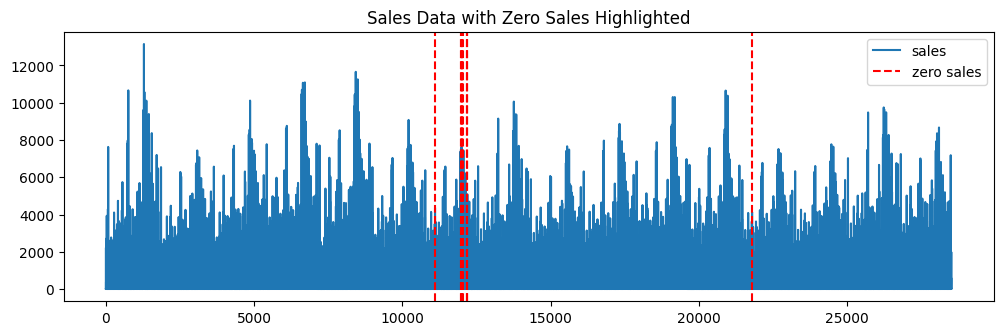

In [ ]:
plt.figure(figsize=(12, 3.5))

plt.plot(df['sales'])

# number of zero sales
M = len(df[df['sales'] == 0])

# zero sales as vertical lines
for i in range(0, M):
    plt.axvline(x=df[df['sales'] == 0].index[i], color='red', linestyle='--')

plt.title('Sales Data with Zero Sales Highlighted')
plt.legend(['sales', 'zero sales'])

plt.show()

> The zero sales aren't regularly spaced and seem to be localized within the series. The first and last vertical lines are quite remote.

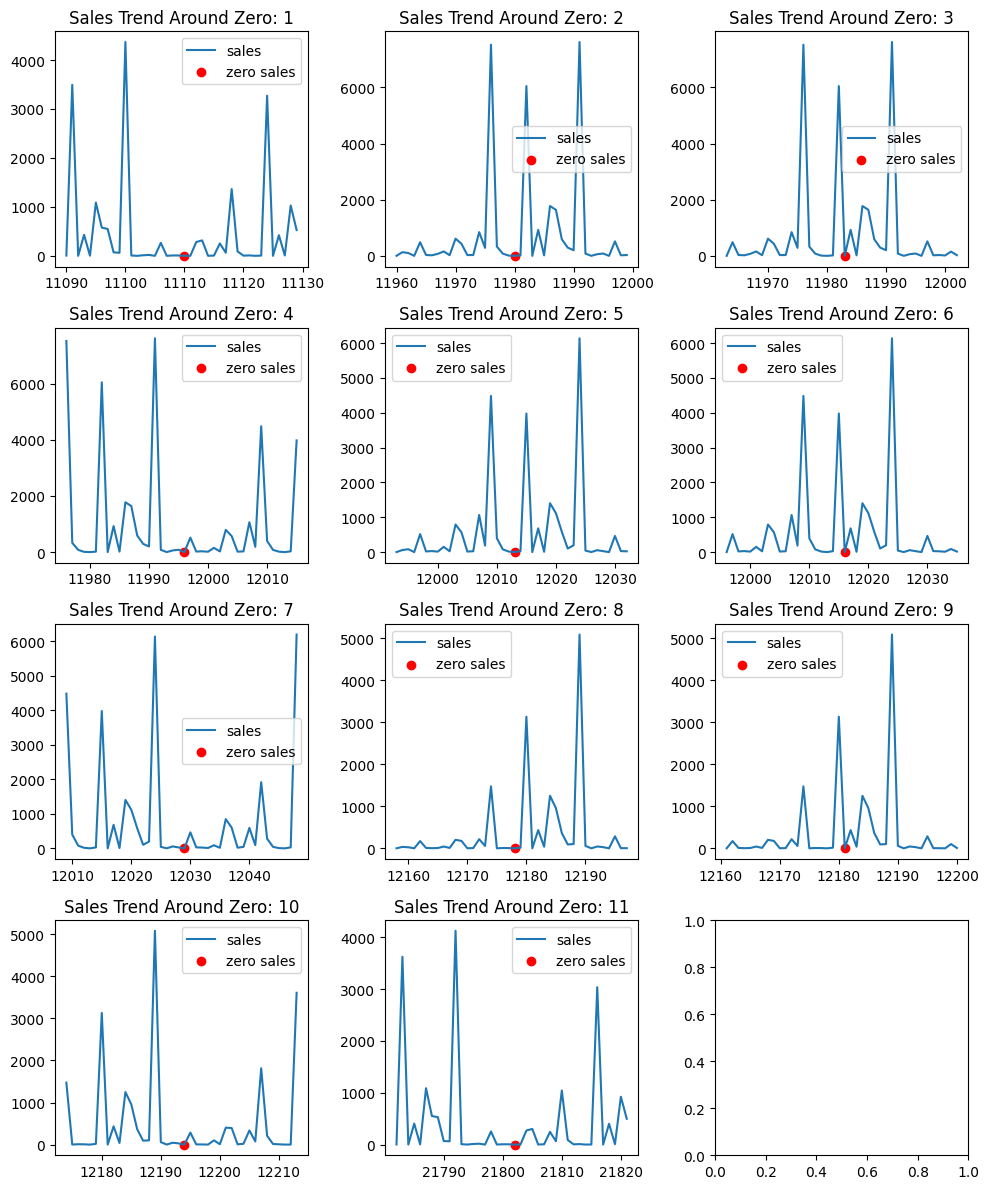

In [ ]:
M = len(df[df['sales'] == 0])

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(10, 12), tight_layout=True)

# flatten the 2D axes array to iterate over
axes = axes.flatten()

# loop through all the zero sales points
for i in range(0, M):
    zero_index = df[df['sales'] == 0].index[i]

    # set the range for the plot around the zero sales point
    start = max(zero_index - 20, 0)
    end = min(zero_index + 20, len(df))

    # select the corresponding subplot axis
    ax = axes[i]

    # plot the sales data
    ax.plot(df[start:end]['sales'], label='sales')

    # highlight the zero sales point
    ax.scatter(zero_index, 0, color='red', label='zero sales')

    ax.set_title(f'Sales Trend Around Zero: {i+1}')
    ax.legend()

plt.show()

> The trends don't look unusual and the zero sales look possible.

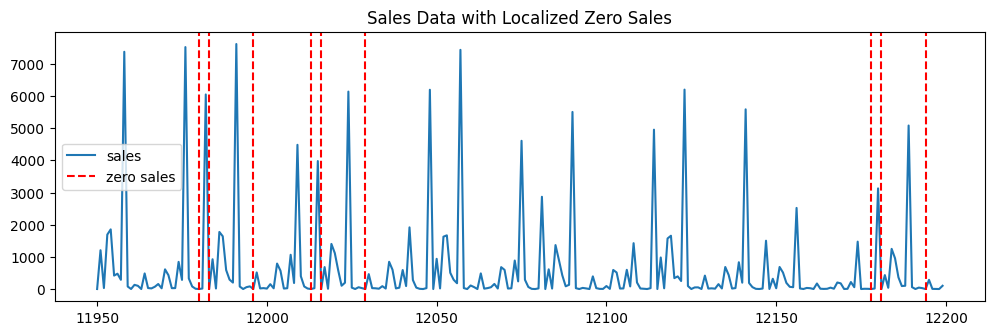

In [ ]:
plt.figure(figsize=(12, 3.5))

plt.plot(df[11950:12200]['sales'])

M = len(df[df['sales'] == 0])

# zero sales as vertical lines
for i in range(1, M - 1):
    plt.axvline(x=df[df['sales'] == 0].index[i], color='red', linestyle='--')

plt.title('Sales Data with Localized Zero Sales')
plt.legend(['sales', 'zero sales'])

plt.show()

> In this view, we can notice some repeating patterns. There are very high spikes between zero values. These rows will remain untouched and will not be impute.

### 3. Is Time Series Modeling Possible?

Determining whether time series forecasting is possible for a given dataset involves a few key steps. Here are several methods and approaches that can help assess the suitability of a time series dataset for forecasting.

* **Stationarity: Is the Data Stationary?**

Stationarity is a key property for many forecasting models, which assumes that the properties of the series (mean, variance, covariance) do not change over time. Many statistical models require the series to be stationary (or be able to transform it to be stationary) to make effective and precise predictions. Non-stationary data can lead to poor model performance, but you can transform non-stationary data into stationary data using techniques like differencing.

To check data stationarity, we can use statistical tests like Augmented Dickey-Fuller (ADF) or Kwiatkowski-Phillips-Schmidt-Shin (KPSS) to formally test for stationarity.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# perform ADF test
result = adfuller(df['sales'])

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Used Lags: {result[2]}')
print(f'Num Observations: {result[3]}')
print(f'Critical Values:')
for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

# interpret p-value
if result[1] < 0.05:
    print('\nData is likely stationary.')  # fail to reject H₀ → likely stationary
else:
    print('\nData is likely non-stationary.')  # reject H₀ → likely non-stationary

ADF Statistic: -14.7812612676187
p-value: 2.2436191602045038e-27
Used Lags: 50
Num Observations: 28461
Critical Values:
	1%: -3.4305797842622394
	5%: -2.8616415582310677
	10%: -2.566824056382294

Data is likely stationary.


> The p-value is less than the significance level, we reject the null hypothesis of non-stationarity and conclude that the series is stationary. ADF statistic with magnitude of -14.78 is quite large (in the negative direction), which suggests strong evidence against the null hypothesis of non-stationarity. The more negative the statistic, the more likely the time series is stationary. Since the ADF statistic (-14.78) is more negative than the critical values at the 1%, 5%, and 10% levels, we reject the null hypothesis that the series has a unit root.

In contrast to the ADF test, which tests the null hypothesis that a series has a unit root (i.e., is non-stationary), the KPSS test assumes the series is stationary under the null hypothesis and looks for evidence to reject that assumption.

In [ ]:
from statsmodels.tsa.stattools import kpss

# perform KPSS test
result = kpss(df['sales'])

print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Used Lags: {result[2]}')
print(f'Critical Values:')
for key, value in result[3].items():
        print('\t{}: {}'.format(key, value))

# interpret p-value
if result[1] > 0.05:
    print('\nData is likely stationary.')  # fail to reject H₀ → likely stationary
else:
    print('\nData is likely non-stationary.')  # reject H₀ → likely non-stationary

KPSS Statistic: 0.10415480858838179
p-value: 0.1
Used Lags: 81
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

Data is likely stationary.


/tmp/ipython-input-17-2538736451.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df['sales'])


> A low KPSS test statistic, with a p-value of 0.1, indicates that we fail to reject the null hypothesis of stationarity. This suggests that the series is likely stationary. The KPSS statistic is also below the critical values, further supporting stationarity.

Both tests display the data to be stationary. No additional transformations need to be introduced.

* **Presence of Seasonality: Is there a Seasonal Pattern?**

Seasonality refers to regular, predictable changes or patterns that occur at specific periods (e.g., monthly, weekly, daily). Identifying seasonality is important because many forecasting models assume that the series has some form of periodicity. Here are some steps to check for seasonality:
* visual inspection: plot the data and look for repeating patterns;
* autocorrelation plots: use autocorrelation function (ACF) and partial autocorrelation function (PACF) plots to look for repeating patterns at regular lags.

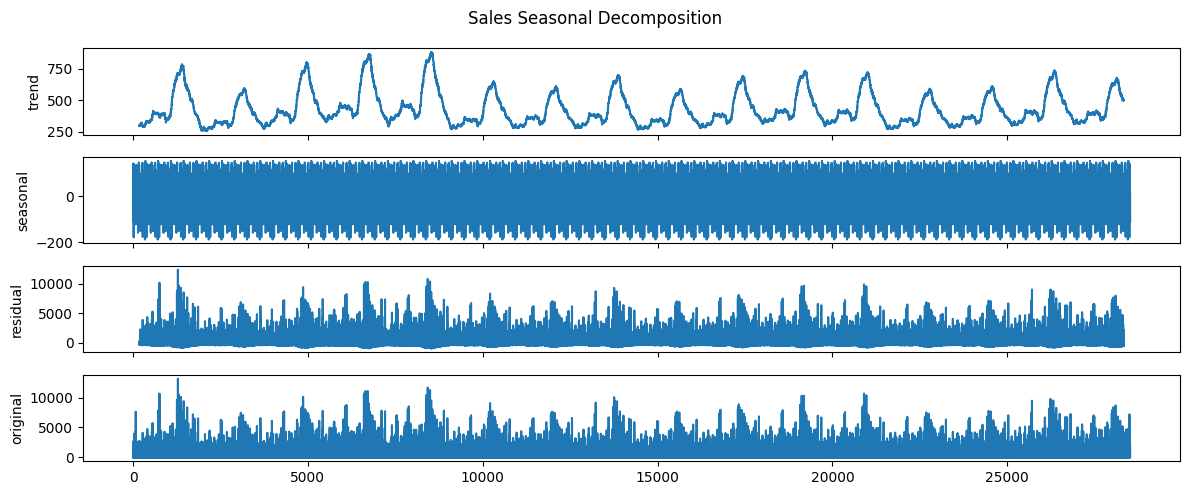

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# plot decomposition components
decomp = seasonal_decompose(df['sales'], model='additive', period=365)

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 5))
fig.suptitle('Sales Seasonal Decomposition')

decomp.trend.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('trend')

decomp.seasonal.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('seasonal')

decomp.resid.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('residual')

decomp.observed.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('original')

plt.tight_layout()
plt.show()

> There are visible seasonality patterns and periodic changes within the series.

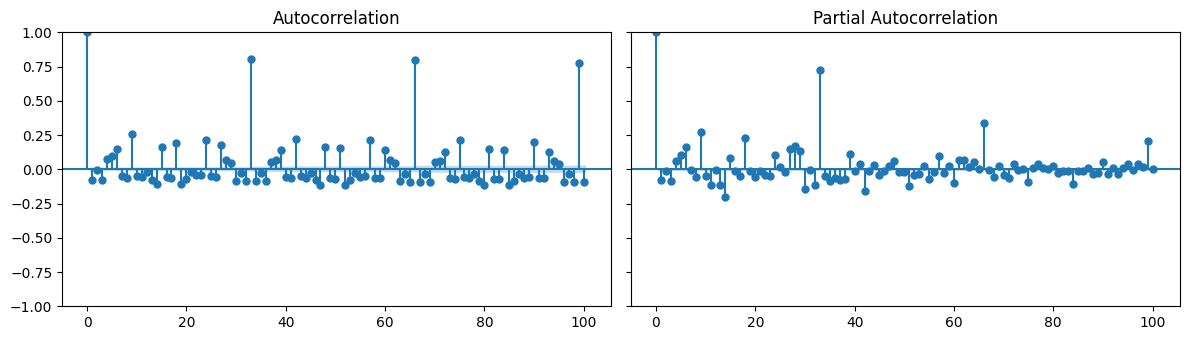

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(12, 3.5))

# plot ACF and PACF
plot_acf(df['sales'], lags=100, ax=axes[0])
plot_pacf(df['sales'], lags=100, ax=axes[1])

plt.tight_layout()
plt.show()

> Some periodicity is visible, especially in the ACF plot (left). Both plots show stationary data - few significant spikes quickly dying out. The most significant spikes are at lag 1, indicating that this lag is important in modeling the underlying data.

* **Trends and Patterns: Is There a Clear Upward or Downward Trend?**

Trends are long-term movements in the data, and detecting them is crucial for model performance. Linear regression, rolling or other trend-detection methods can help. We already previously detected patterns and seasonality in the series, so will introduce a few additional techniques.

We can perform trend detection via differencing. In this case, we subtract the previous observation from the current observation to isolate the trend.

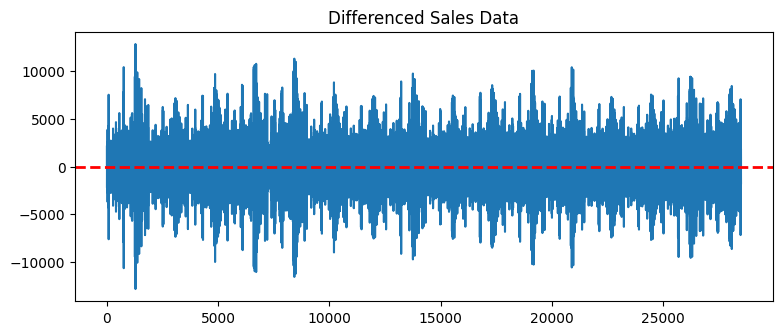

In [ ]:
# difference sales data
df['sales_diff'] = df['sales'].diff()

df['sales_diff'].plot(figsize=(9, 3.5))

plt.axhline(0, color='r', linestyle='dashed', linewidth=2)
plt.title('Differenced Sales Data')

plt.show()

We can also extract cycle and trend using Hodrick-Prescott (HP) filter. The HP filter is good for removing short-term fluctuations from the data.

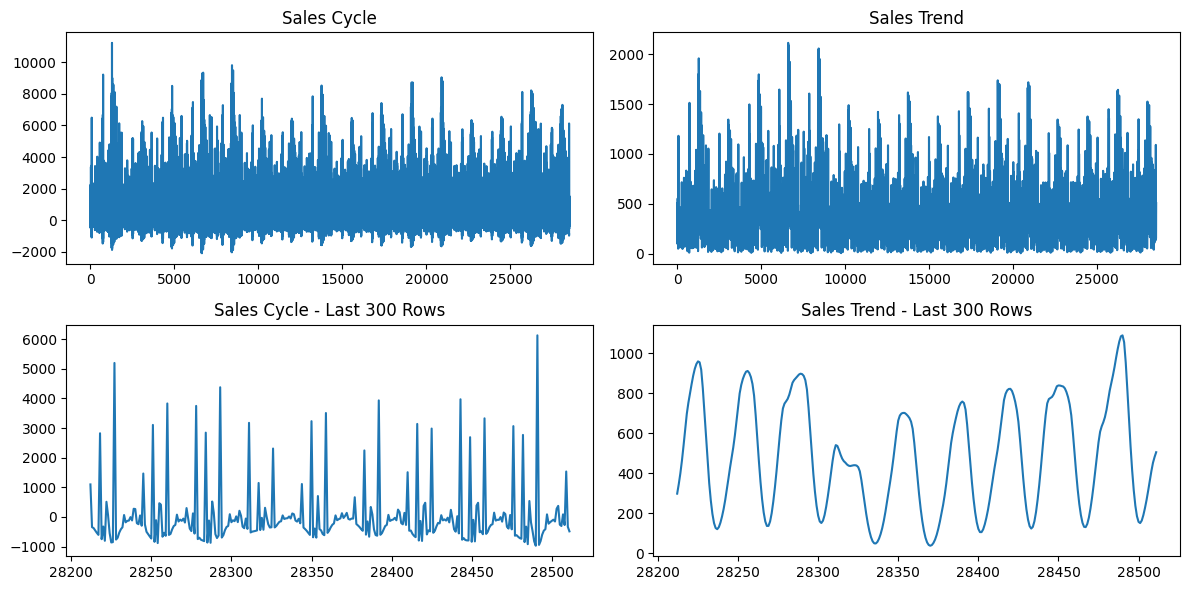

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# apply HP filter
df_cycle, df_trend = hpfilter(df['sales'], lamb=100)

fig, axes = plt.subplots(
    ncols=2, nrows=2,
    sharex=False,
    figsize=(12, 6),
    tight_layout=True,
    gridspec_kw={'height_ratios': [2, 2], 'width_ratios': [2, 2]},
    )

# flatten the 2D axes array
axes = axes.flatten()

# sales cycle and moving average
axes[0].plot(df_cycle)
axes[0].set_title('Sales Cycle')
#axes[0].plot(df_cycle.rolling(5).mean())

# sales trend and moving average
axes[1].plot(df_trend)
axes[1].set_title(f'Sales Trend')
#axes[1].plot(df_trend.rolling(100).mean())

N = 300
# more detail
axes[2].plot(df_cycle.tail(N))
axes[2].set_title(f'Sales Cycle - Last {N} Rows')

axes[3].plot(df_trend.tail(N))
axes[3].set_title(f'Sales Trend - Last {N} Rows')

plt.tight_layout()
plt.show()

> All methods proved, the dataset meets these criteria and time series forecasting can be effectively applied.

### 4. Data Preprocessing

The data will be prepared for time series modeling. The dataset needs to be reframed into a supervised form. This means we need to generate lag observations by shifting the target variable. While the XGBoost does not need any appropriate transformations, the LSTM requires scaling. Finally, the dataframe will be partitioned into train, test, and validation subsets.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# set 'id' as index
df.set_index('id', inplace=True)

# keep only sales
df = df[['sales']]

sales = df['sales'].values
sales = sales.reshape(-1, 1)

# normalize sales
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(sales)

In [ ]:
# convert the time series data to sequences (X, y)
def generate_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])

    return np.array(X), np.array(y)

time_step = 20
X, y = generate_dataset(scaled_sales, time_step)

# reshape X to be 3D (samples, timesteps, features) - for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# use 70% for training, 15% for validation, and 15% for testing
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

# split data into training, validation, and test sets
X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

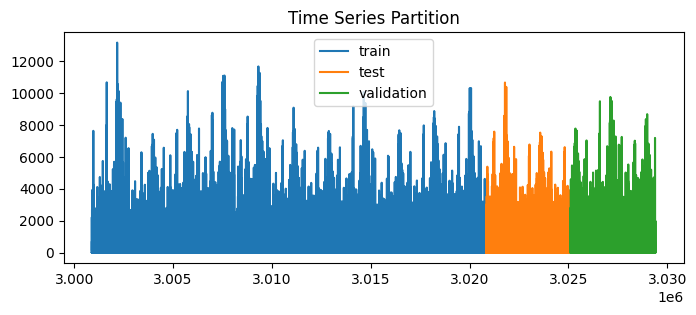

In [ ]:
# plot train/test/validation split
plt.figure(figsize=(8, 3))

plt.plot(df[:train_size], label='train')
plt.plot(df[train_size:train_size+val_size], label='test')
plt.plot(df[train_size+val_size:], label='validation')
plt.title('Time Series Partition')
plt.legend()

plt.show()

### 5. Developing LSTM

Our baseline (benchmark) model will be LSTM (long short-term memory), a popular deep learning technique, which handles both linear and non-linear data, excels in capturing long-term temporal dependencies, and can model more intricate time series patterns. It's a more flexible solution for diverse datasets. It can also handle non-stationary series. Below are the characteristics for the LSTM:
* 64 and 32 units: reasonable starting points in a bottleneck matter;
* tanh activation function: used to control the flow of information through the cell state and useful for extracting hidden states;
* 2 dropout layers: LSTM is prone to overfitting, so regularization should prevent this;
* 1 dense layer: a typical setup for regression problems, as we are predicting a single continuous value;
* MSE (Mean Squared Error) loss function: standard loss function for regression problems, and it's appropriate for time series prediction as well.

We will use LSTM for feature extraction and combine it with the predictive power of gradient boosting XGBoost model later on.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

# LSTM architecture
lstm = Sequential(name='LSTM')
lstm.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(time_step, 1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(32))
lstm.add(Dropout(0.2))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse')

lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit LSTM model
history = lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=64,
    verbose=1,
    )

Epoch 1/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 2/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 3/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 4/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 5/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0059 - val_loss: 0.0041
Epoch 6/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 7/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 8/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 9/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 10/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 11/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 12/80
312/312 ━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# export LSTM as serialized file
# file location in G-Drive
data_path = '/content/drive/My Drive/lstm_sales.h5'
lstm.save(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

from google.colab import drive
drive.mount('/content/drive')

# path to H5 file in Google Drive
model_path = '/content/drive/My Drive/lstm_sales.h5'

# load the keras model
lstm = load_model(model_path, compile=False)
lstm.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

# check the model architecture
lstm.summary()
'''

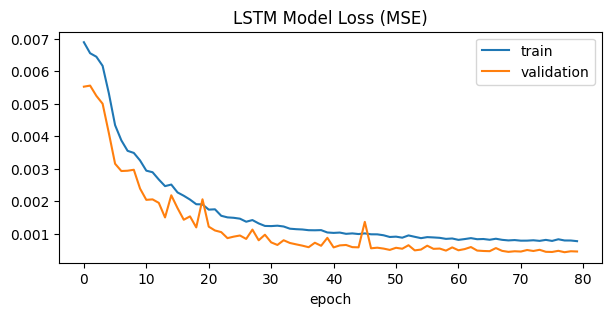

In [ ]:
# plot the learning curves
plt.figure(figsize=(7, 3))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('LSTM Model Loss (MSE)')
plt.xlabel('epoch')
plt.legend()
plt.show()

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


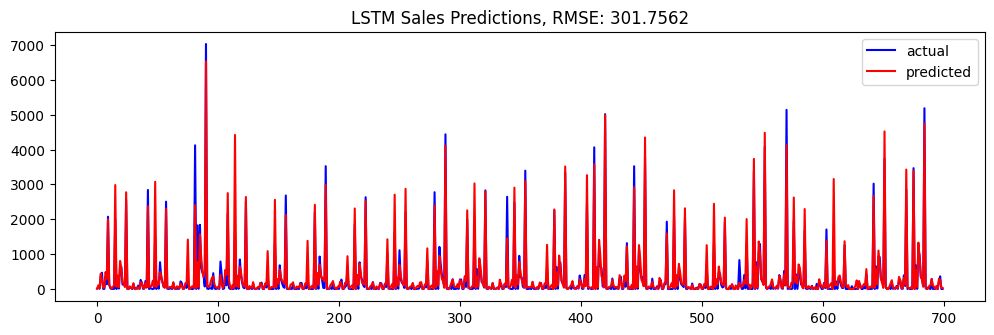

In [ ]:
# predict on test set
lstm_predictions = lstm.predict(X_test)

# ensure no predictions are neagtive
#lstm_predictions = np.clip(lstm_predictions, 0, 1)
lstm_predictions = np.clip(lstm_predictions, 0, None)

# inverse transform the predictions and the actual sales to original scale
yhat_lstm = scaler.inverse_transform(lstm_predictions)
actual_sales = scaler.inverse_transform(y_test.reshape(-1, 1))

# RMSE for LSTM
rmse_lstm = np.sqrt(mean_squared_error(actual_sales, yhat_lstm))

# plot portion actual vs predicted
plt.figure(figsize=(12, 3.5))

plt.plot(actual_sales[700:1400], color='blue', label='actual')
plt.plot(yhat_lstm[700:1400], color='red', label='predicted')
plt.title(f'LSTM Sales Predictions, RMSE: {rmse_lstm:.4f}')

plt.legend()
plt.show()

In [ ]:
# print LSTM evaluation metrics
print(f'R²:   {r2_score(actual_sales, yhat_lstm):.8f}')
print(f'RMSE: {rmse_lstm:.8f}')

R²:   0.92803958
RMSE: 301.75624607


> The LSTM alone already returns quite accurate predictions. The learning curves for MSE display gradual decline with a slight divergence between the curves, meaning it generalizes well. Visually, the predicted sales overlap the actual sales pretty good. The LSTM is a decent baseline, but still leaves significant room for improvement, especially in RMSE.

### 6. Feature Stacking (XGB on LSTM Features)

Now, with XGBoost we will use the features (hidden representations or last hidden states) from LSTM as inputs to make new estimates. The predictions of the base model (LSTM) are stacked and used as input to the final model (XGBoost) to compute the prediction. Tree-based algorithms are especially good at capturing complex relationships. The conceptual formula:

$$\hat{y} = \text{XGB}\left([h_\text{LSTM}, y]\right)$$

where $h$ is the hidden states array and $y$ contains numeric target.

In [ ]:
# use the LSTM model to extract features (hidden states)
train_features = lstm.predict(X_train)
test_features = lstm.predict(X_test)
val_features = lstm.predict(X_val)

624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [ ]:
import xgboost as xgb

# train XGBoost model on hidden states
xgb_mod_feat = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    )

xgb_mod_feat.fit(
    train_features, y_train,
    eval_set=[(train_features, y_train), (val_features, y_val)],
    verbose=False,
    )

# make predictions on the test data
xgb_predictions = xgb_mod_feat.predict(y_test)

# ensure no predictions are neagtive
#xgb_predictions = np.clip(xgb_predictions, 0, 1)
xgb_predictions = np.clip(xgb_predictions, 0, None)

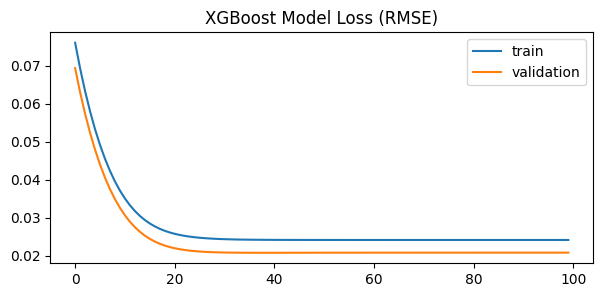

In [ ]:
# retrieve performance metrics
results_xgb = xgb_mod_feat.evals_result()

# plot the learning curve
plt.figure(figsize=(7, 3))

plt.plot(results_xgb['validation_0']['rmse'], label='train')
plt.plot(results_xgb['validation_1']['rmse'], label='validation')
plt.title('XGBoost Model Loss (RMSE)')
plt.xlabel('estimator')
plt.legend()
plt.show()

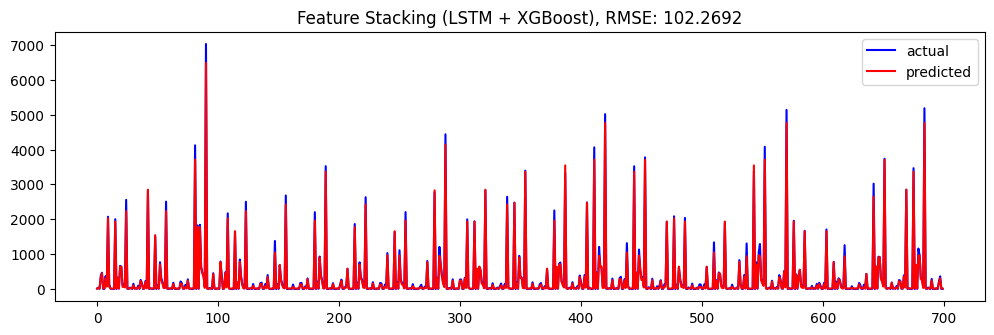

In [ ]:
# inverse transform the predictions and the actual sales to original scale
yhat_xgb = scaler.inverse_transform(xgb_predictions.reshape(-1, 1))
actual_sales = scaler.inverse_transform(y_test.reshape(-1, 1))

# RMSE for feature stacking
rmse_feat = np.sqrt(mean_squared_error(actual_sales, yhat_xgb))

# plot portion actual vs predicted
plt.figure(figsize=(12, 3.5))

plt.plot(actual_sales[700:1400], color='blue', label='actual')
plt.plot(yhat_xgb[700:1400], color='red', label='predicted')
plt.title(f'Feature Stacking (LSTM + XGBoost), RMSE: {rmse_feat:.4f}')

plt.legend()
plt.show()

In [ ]:
# show feature stacking evaluation metrics
print(f'R²:   {r2_score(actual_sales, yhat_xgb):.8f}')
print(f'RMSE: {rmse_feat:.8f}')

R²:   0.99173447
RMSE: 102.26918501


> This hybridization approach greatly leveraged the accuracy compared to LSTM.

### 7. Residual Learning (XGB on LSTM Residuals)

This technique analyzes the residuals to assess and improve the time series model. Residuals are a key diagnostic tool for evaluating the quality of a time series model, and their properties can reveal whether the model has adequately captured the underlying patterns in the data. A residual is the difference between actual observed sales and fitted sales and is expressed as:

$$\text{r} = y - \hat{y}_\text{LSTM}$$

The XGBoost regressor estimates its own residuals, which are simply added as corrections to the previous LSTM predictions:

$$\hat{y}_\text{final} = \hat{y}_\text{LSTM} + \hat{r}_\text{XGB}$$

In [ ]:
# compute LSTM residuals (in original scale)
resids_lstm = actual_sales - yhat_lstm

# flatten sequences from 3D to 2D for XGBoost: (samples, time_steps)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)
X_val_xgb = X_val.reshape(X_val.shape[0], -1)

# train XGBoost model on residuals
xgb_mod_resid = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    )

xgb_mod_resid.fit(
    X_test_xgb, resids_lstm,
    eval_set=[(X_val_xgb, y_val)],
    verbose=False,
    )

# make predictions on the test data
xgb_corrections = xgb_mod_resid.predict(X_test_xgb)

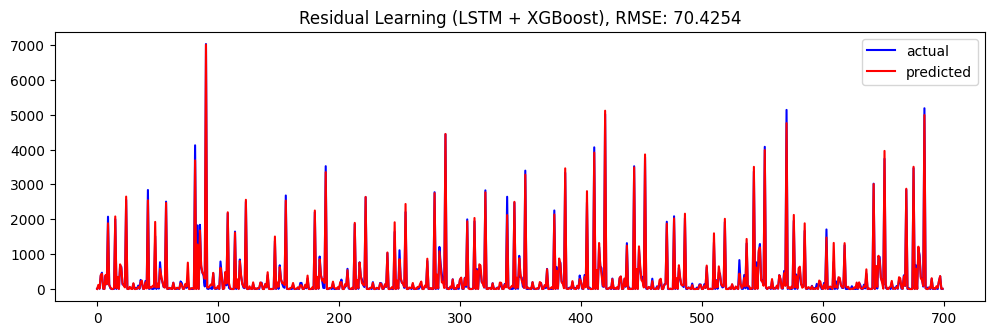

In [ ]:
# add corrections to LSTM predictions (in original scale)
final_predictions = yhat_lstm + xgb_corrections.reshape(-1, 1)
actual_sales = scaler.inverse_transform(y_test.reshape(-1, 1))

# ensure no predictions are neagtive
#final_predictions = np.clip(final_predictions, 0, 1)
final_predictions = np.clip(final_predictions, 0, None)

# RMSE for residual learning
rmse_resid = np.sqrt(mean_squared_error(actual_sales, final_predictions))

# plot portion actual vs predicted
plt.figure(figsize=(12, 3.5))

plt.plot(actual_sales[700:1400], color='blue', label='actual')
plt.plot(final_predictions[700:1400], color='red', label='predicted')
plt.title(f'Residual Learning (LSTM + XGBoost), RMSE: {rmse_resid:.4f}')

plt.legend()
plt.show()

In [ ]:
# show residual learning evaluation metrics
print(f'R²:   {r2_score(actual_sales, final_predictions):.8f}')
print(f'RMSE: {rmse_resid:.8f}')

R²:   0.99608041
RMSE: 70.42543482


### 8. Ensemble Averaging

This approach is very simple and straight forward. We train both models independently and average or weight their predictions. A higher weight is applied on the model with better performance, in this case lower RMSE. The formula for final prediction:

$$\hat{y} = \alpha_\text{LSTM} \cdot \hat{y}_\text{LSTM} + \alpha_\text{XGB} \cdot \hat{y}_\text{XGB}$$

where $\alpha$ is the model's weighting factor. The sum of all weights equals 1.0 and can be expressed accordingly:

$$\alpha_\text{LSTM} = \left(\frac{1 - \text{RMSE}_\text{LSTM}}{\text{RMSE}_\text{LSTM} + \text{RMSE}_\text{XGB}}\right)$$

$$\alpha_\text{XGB} = \left(\frac{1 - \text{RMSE}_\text{XGB}}{\text{RMSE}_\text{LSTM} + \text{RMSE}_\text{XGB}}\right)$$

Note that we can use any other evaluation metric in the weights. This time, hyparameter tuning will be performed on the XGBoost estimator for better fitting results.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# flatten sequences from 3D to 2D for XGBoost: (samples, time_steps)
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)
X_val_xgb = X_val.reshape(X_val.shape[0], -1)

# default base model
xgb_base = xgb.XGBRegressor(objective='reg:squarederror')

# hyperparameters to tune
param_dist = {
    'learning_rate': np.arange(0.01, 0.2, 0.01),
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 6, 9, 12],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'scale_pos_weight': [1, 5, 10]
}

# setup RandomizedSearchCV and fit the model
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42,
    )

random_search.fit(
    X_train_xgb, y_train,
    eval_set=[(X_train_xgb, y_train), (X_val_xgb, y_val)],
    verbose=False,
    )

# get the best parameters and best score
print('Best parameters found:\n')
pprint(random_search.best_params_)
print('\nBest score (negative MSE): ', random_search.best_score_)

# set the best XGBoost model for prediction
best_xgb_mod = random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:

{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': np.float64(0.060000000000000005),
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 200,
 'scale_pos_weight': 10,
 'subsample': 0.7}

Best score (negative MSE):  -0.00019872710807005217


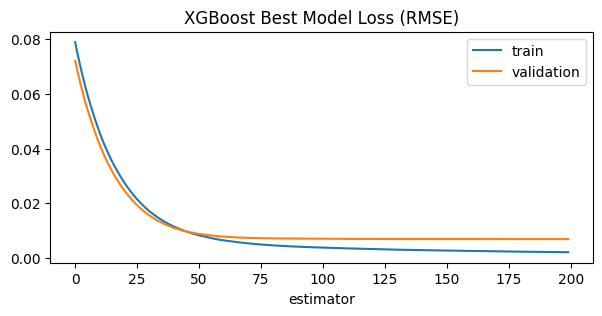

In [ ]:
# retrieve performance metrics
results_best_xgb = best_xgb_mod.evals_result()

# plot the learning curve
plt.figure(figsize=(7, 3))

plt.plot(results_best_xgb ['validation_0']['rmse'], label='train')
plt.plot(results_best_xgb ['validation_1']['rmse'], label='validation')
plt.title('XGBoost Best Model Loss (RMSE)')
plt.xlabel('estimator')
plt.legend()
plt.show()

After training the XGBoost model, new predictions are generated and $\alpha$ weights for both models are computed. Ideally, both weights should be close to 0.5 for higher efficiency. Lastly, we combine LSTM and XGBoost estimates by weighing them for final predictions.

In [ ]:
# make predictions on the test data
xgb_pred_hyper = best_xgb_mod.predict(X_test_xgb)

# ensure no predictions are neagtive
#xgb_pred_hyper = np.clip(xgb_pred_hyper, 0, 1)
xgb_pred_hyper = np.clip(xgb_pred_hyper, 0, None)

# inverse transform the predictions and the actual sales to original scale
yhat_xgb_hyper = scaler.inverse_transform(xgb_pred_hyper.reshape(-1, 1))
actual_sales = scaler.inverse_transform(y_test.reshape(-1, 1))

# RMSE for new XGBoost
rmse_xgb_hyper = np.sqrt(mean_squared_error(actual_sales, yhat_xgb_hyper))

In [ ]:
# compute weights for each model
alpha_lstm = (1 - (rmse_lstm / (rmse_lstm + rmse_xgb_hyper)))
alpha_xgb = (1 - (rmse_xgb_hyper / (rmse_lstm + rmse_xgb_hyper)))

# check if weights are equal 1.00
alpha_lstm + alpha_xgb == 1.0

np.True_

In [ ]:
# display weights
print(f'LSTM weight:    {alpha_lstm:.6f}')
print(f'XGBoost weight: {alpha_xgb:.6f}')

LSTM weight:    0.290640
XGBoost weight: 0.709360


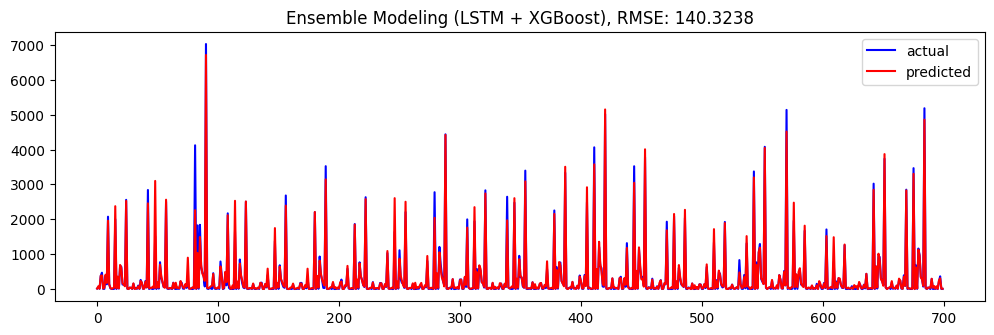

In [ ]:
# ensemble averaged predictions
yhat_ensem = alpha_xgb * yhat_xgb_hyper + alpha_lstm * yhat_lstm

# RMSE for ensemble modeling
rmse_ensem = np.sqrt(mean_squared_error(actual_sales, yhat_ensem))

# plot portion actual vs predicted
plt.figure(figsize=(12, 3.5))

plt.plot(actual_sales[700:1400], color='blue', label='actual')
plt.plot(yhat_ensem[700:1400], color='red', label='predicted')
plt.title(f'Ensemble Modeling (LSTM + XGBoost), RMSE: {rmse_ensem:.4f}')

plt.legend()
plt.show()

In [ ]:
# show ensemble averaging evaluation metrics
print(f'R²:   {r2_score(actual_sales, yhat_ensem):.8f}')
print(f'RMSE: {rmse_ensem:.8f}')

R²:   0.98443877
RMSE: 140.32382114


|                        |   **RMSE**  |    **R²**  |
|------------------------|-------------|------------|
| **LSTM (Baseline)**    |   301.7562  |   0.9280   |
| **Feature Stacking**   |   102.2692  |   0.9917   |
| **Residual Learning**  | **70.4254** | **0.9961** |
| **Ensemble Averaging** |   140.3238  |   0.9844   |

> The results are very strong overall, and show meaningful improvement from the baseline LSTM model through increasingly sophisticated hybrid approaches. The  standalone LSTM model is a decent baseline, but still displays significant room for improvement.<br>
* **Feature stacking** displays huge improvement over LSTM alone. This suggests that XGBoost is very effective at learning non-linear relationships from LSTM's internal representations.<br>
* **Residual learning** is the best and most powerful strategy. This means LSTM is capturing the base trend, and XGBoost corrects the remaining errors. The time series has strong temporal patterns. It reflects that the models are complementary, not redundant.<br>
* **Ensemble modeling** is worse than stacking or residual learning, but still better than LSTM alone. Simple averaging can sometimes dilute the strengths of the individual models. This approach would have been much more effective when models are equally strong (have similar weights). The tuned XGBoost regressor was significantly more powerful than LSTM.

### 9. Conclusions

Model hybridization proved to be a beneficial approach for time series forecasting. Each chosen algorithm has different assumptions and benefits. Combining those assets allows us to leverage the overall performance and develop a more sophisticated forecaster.

This notebook introduced hybrid modeling strategies combining LSTM and XGBoost. The LSTM component was used for capturing temporal dependencies and the tree-based model was used for predicting based on the features generated by LSTM. The final results of these hybridization combinations are more accurate estimates.

While the LSTM alone performs very decent, **residual learning** is the best technique for this dataset. It's not only lowest in RMSE but also has the highest R², indicating it generalizes well and captures nearly all variance in the data.